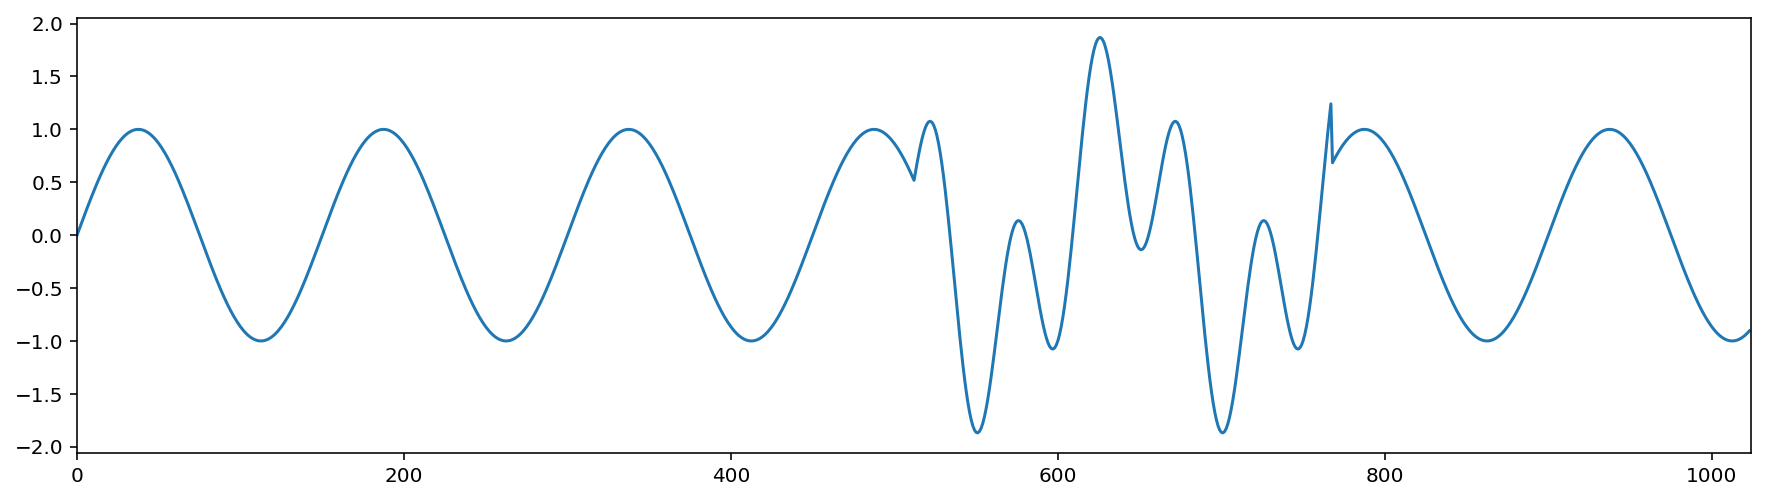

In [24]:
import numpy as np
import pylab as pl
%matplotlib inline
pl.rcParams["figure.figsize"] = (15,4)
# Тестовый временной ряд
Ns=1024
Nlo=0 
Nhi=Ns
dt =1.
#Синусоиды с периодами 50 и 150
t=np.arange(0.0,dt*Ns,dt)
A=np.sin(2.0*np.pi*t/150.)
B=np.sin(2.0*np.pi*t/50.)
A[512:768]+=B[0:256]
x=A[:]
pl.plot(t,x)
_=pl.xlim([0, Ns])


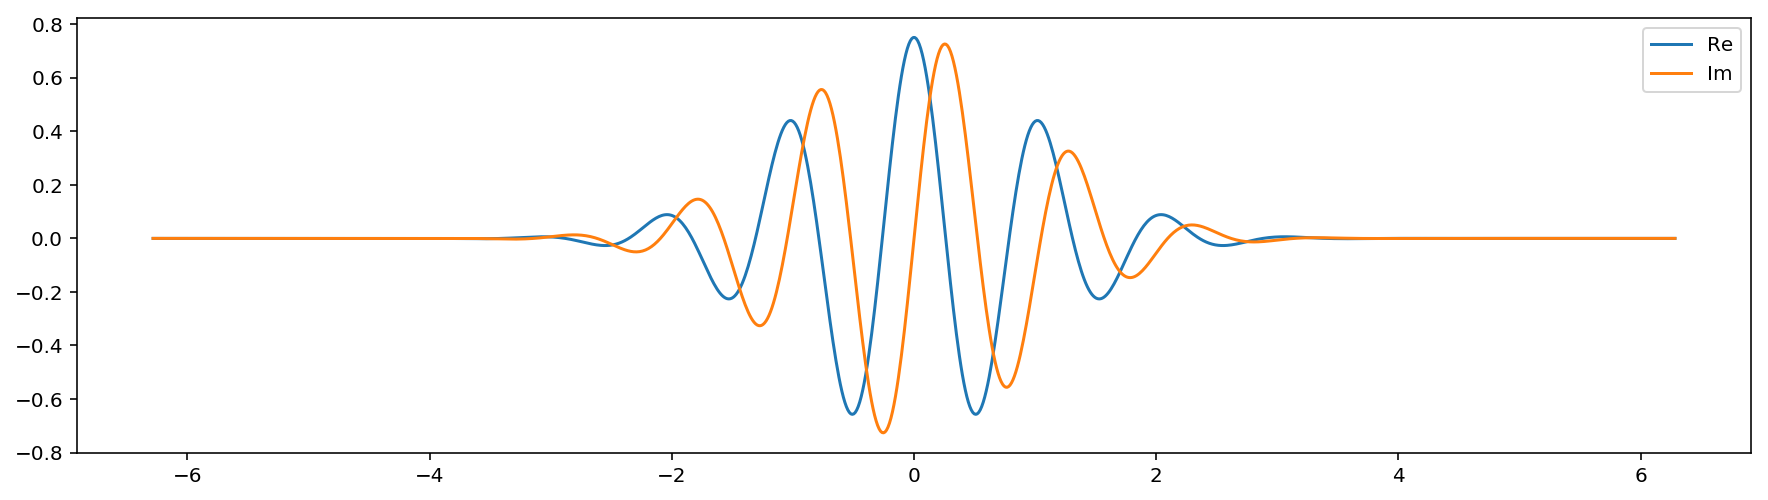

In [25]:
def morlet(x, w0=6.0):
    return np.pi**-0.25 * np.exp(1j*w0*x)*np.exp(-0.5*x**2)

m_x = np.linspace(-2 * np.pi, 2 * np.pi, 1024)
m = morlet(m_x)
pl.plot(m_x,np.real(m), label="Re")
pl.plot(m_x,np.imag(m), label="Im")
_ = pl.legend()


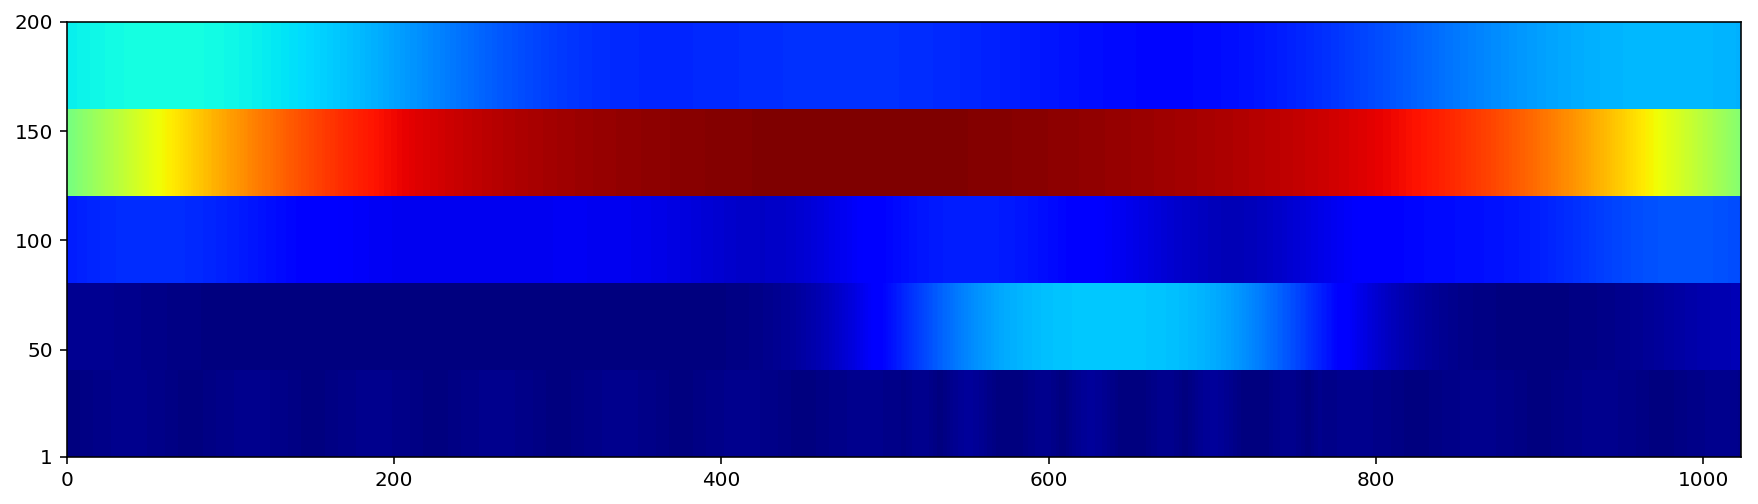

In [26]:
def conj(a):
    return np.real(a)-1j*np.imag(a)
#Параметры смещений
n=np.arange(Nlo , Nhi)
#Параметры масштабов
s=np.array([1, 50, 100, 150, 200])
w0=6. #Частота вейвлета
fwl=4* np.pi/(w0 + np.sqrt(2.0+w0**2)) # длина волны вейвлета, формула (4.3)
sf=s/fwl #Нормализация масштабов
#вычисление по формуле (4.2)
W=np.zeros([len(s), len(n)],dtype=np.complex64)
for i in range(len(s)):
    for j in range(len(n)):
        for n_ in range (Ns):
            W[i,j]= W[i,j]+x[n_]*conj(morlet((n_-n[j])*dt/sf[i],w0=w0))
pl.rcParams["figure.figsize"] = (15,4)
im=pl.imshow(np.abs(W),
             cmap=pl.cm.jet,
             extent=[n[0],n[-1],s[-1],s[0]],
             aspect='auto',
             interpolation="nearest")
pl.ylim(s[0],s[-1])
_=pl.yticks(s)


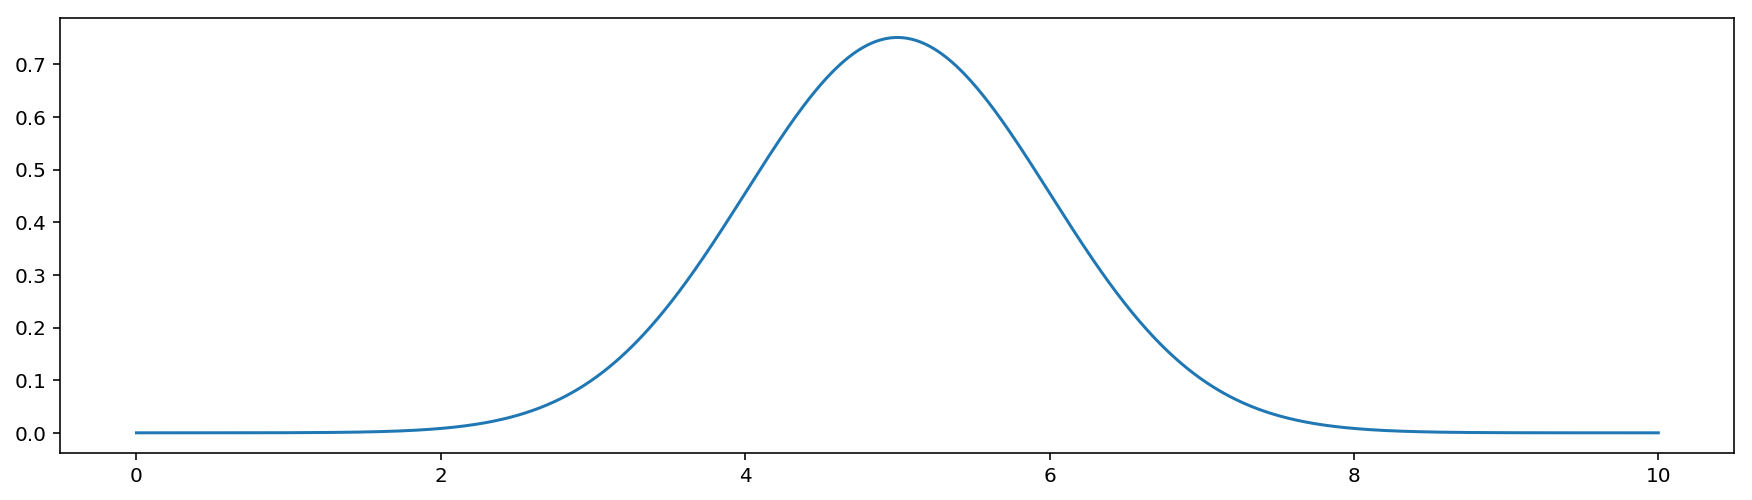

In [27]:
def hat_morlet(s_omega, w0=5.):
    H= np.ones(len(s_omega))
    n=len(s_omega)
    H[s_omega < 0.0] = 0.0 #функция Хэвисайда
    xhat=0.75112554*( np.exp(-(s_omega-w0)**2/2.0))*H
    return xhat

s_omega = np.linspace(0, 10, 1024)
m = hat_morlet(s_omega)
_ = pl.plot(s_omega, m)


In [28]:
# Функции, вычисляющие БПФ
def _W(k,N, n=1, inv=False):
    w=-2*np.pi*1j*k*n/N
    if not inv: return np.exp(w)
    else: return np.exp(-w)

def fft(x, inv=False):
    N=len(x)
    if N % 2 > 0:
        raise ValueError("Количество отсчетов должно быть степенью 2-ки")
    Y1=[]
    Y2=[]
    if N == 2: #условие окончания рекурсии
        return [x[0]+x[1], x[0]-x[1]]
    else:
        x1=x[::2]  #четные
        x2=x[1::2] #нечетные
        X1 = fft(x1, inv=inv)
        X2 = fft(x2, inv=inv)     
    for k in range(N/2):
        tmp=_W(k,N, inv=inv)*X2[k]
        Y1.append(X1[k]+ tmp)
        Y2.append(X1[k]- tmp)
    return Y1+Y2 #объединение двух списков


In [0]:
s=np.arange(1,250, step=1) #масштабы вейвлета
hat_x =fft(x)
omega_ = [2* np.pi * k/ Ns/dt for k in range(0, Ns/2)] #формула (5)
_omega = [-2* np.pi * k/ Ns/dt for k in range(Ns/2, Ns)]
omega = np.array(omega_+_omega)
w0=5.
fwl=4* np.pi/(w0 + np.sqrt(2.0+w0**2))
sf=s/fwl
# Реализация формулы (4), но с учетом того, что затем будет применено обратное БПФ
Ws=np.zeros([len(s), Ns],dtype=np.complex64)
for scaleindex in range(len(s)):
    currentscale=sf[scaleindex]
    s_omega = omega*currentscale
    psihat=hat_morlet(s_omega,w0)
    convhat = psihat * hat_x
    W = np.array(fft(convhat, inv=True))
    Ws[scaleindex,:]=W[:]/Ns


In [0]:
pl.rcParams["figure.figsize"] = (15,8)
pl.subplot(2,1,1)
pl.plot(t,x)
_=pl.xlim([0, Ns])
pl.subplot(2,1,2)
im=pl.imshow(np.abs(Ws),
             cmap=pl.cm.jet,
             extent=[n[0],n[-1],s[-1],s[0]],
             aspect='auto',
             interpolation="nearest")
_=pl.ylim(s[0],s[-1])


In [0]:
pl.rcParams["figure.figsize"] = (15,4)
X=fft(x)
A=np.abs(X)
P=np.angle(X)
N=len(A)
nu=np.arange(N)/dt/N
np.seterr(divide='ignore')
T=1/nu
pl.subplot(2,1,1)
pl.semilogy(T[0:N//2], A[0:N//2])
pl.xlim([0, 400])
pl.grid()
pl.subplot(2,1,2)
pl.plot(T[0:N//2], P[0:N//2])
pl.xlim([0, 400])
pl.grid()


In [0]:
pl.rcParams["figure.figsize"] = (15,4)
url = 'http://www.sidc.be/silso/DATA/SN_y_tot_V2.0.txt'
data = np.genfromtxt(url)
y=data[:,0]
N=data[:,1]
_=pl.plot(y,N)
